https://app.diagrams.net/#G1kOLxSIqMuavf4peNEdkWelzKj6Rcp3nl

# Install requirements

In [99]:
import sys
import os

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install spotipy
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install lyricsgenius
!{sys.executable} -m pip install NRCLex

isDatabricks = False

# Imports

In [38]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import multiprocessing
from multiprocessing import Pool
import pandas as pd
import requests
from urllib import request as urllib2
import json
from bs4 import BeautifulSoup
import re
import string

import lyricsgenius
from nrclex import NRCLex
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import uuid
import time

[nltk_data] Downloading package punkt to /home/valerio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valerio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/valerio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Spotify connection

In [51]:
os.environ["SPOTIPY_CLIENT_ID"] = "9434b51d2fde473384c68c79130534f1"
os.environ["SPOTIPY_CLIENT_SECRET"] = "371433b0726f4ede8bce202e9102f121"
os.environ["SPOTIPY_REDIRECT_URI"] = "https://developer.spotify.com/dashboard/applications/9434b51d2fde473384c68c79130534f1"
os.environ["SPOTIPY_CLIENT_USERNAME"] = "11154156130"
os.environ['PYSPARK_PYTHON']=sys.executable

# Spark initialization

In [69]:
spark = SparkSession.builder.appName("BigData Project").getOrCreate()
sqlcontext = SQLContext(spark)

client_id = "9434b51d2fde473384c68c79130534f1"
client_secret = "64ff22636db44b68992ef49b1c9eaaf4"
username = "11154156130"

scope = "playlist-modify-public playlist-modify-private playlist-read-private playlist-read-collaborative"

redirect_uri = "https://developer.spotify.com/dashboard/applications/9434b51d2fde473384c68c79130534f1"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
print(token)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


BQBX0S5sXvopwBvP2QXsi8p0781nfQJYPEHqbyJg965xoiEfNIybDsNglLzW_xrVk7ZaQGeShCv--MD93U83MOHv742lIbkzRqfTt1HEPZ9ewRsYsLhF2QFBDZou9P9DSXe2ft4x7FLe5urIgcNqaioLtH5yrRf_s3CScZBuLLtjjWkRvvliV2aBubycT1MBlXYFVfiNP9mu9FJovMuSNcJlT_BNuQ


In [53]:
spark

# Grab spotify playlists and collect tracks information

In [5]:
playlists = sp.user_playlists('spotify')
print(playlists)

playlist_ids = []
while playlists:
    for i, playlist in enumerate(playlists['items']):
        playlist_ids.append(playlist['id'])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

KeyboardInterrupt: 

In [ ]:
ids = []
def getTrackIDs(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']: #[:50]:
        track = item['track']
        if track is not None:
            ids.append(track['id'])
    return ids

def getSpotifyTrackIDs(playlist_id):
    return getTrackIDs('spotify', playlist_id)
  
#pool_obj = multiprocessing.Pool()
#ids = pool_obj.map(getSpotifyTrackIDs,playlist_ids)

p = Pool(8)
p.map(f, [1, 2, 3, 4])
p.close()
p.join()


for i in playlist_ids:
    ids = getTrackIDs('spotify', i) #playlist

In [ ]:
print(len(ids))

In [71]:
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)
    
    trackid = id
    
    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']

    track = [trackid, name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    
    return track

In [ ]:

# loop over track ids to get audio features for each track
tracks = []
toCalcIds = ids[:5000]

#pool_obj = multiprocessing.Pool()
#tracks = pool_obj.map(getTrackFeatures,ids)

for i in range(len(toCalcIds)):
    sys.stdout.write("\rProcessing Track Number %i" % i)
    sys.stdout.write("\Tracks Number %i" % len(toCalcIds))
    sys.stdout.flush()
    try: 
        track = getTrackFeatures(toCalcIds[i])
        tracks.append(track)
    except:
        pass


In [ ]:

# create dataset
df = pd.DataFrame(tracks, columns = ['trackid', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])


In [ ]:
df = spark.createDataFrame(df)

In [ ]:
schema = df.printSchema()
schema

In [ ]:
if isDatabricks :
    %fs rm -r '/FileStore/tables/spotify.csv'

In [ ]:
if isDatabricks :
    dbutils.fs.rm("/FileStore/tables/spotify.csv")
    df.write.format('com.databricks.spark.csv').option('header', 'true').save('dbfs:/FileStore/tables/spotify.csv')
else:
    df.write.format("com.databricks.spark.csv").option('header', 'true').save('spotify.csv')

In [ ]:
df

In [6]:
if isDatabricks :
    df = sqlcontext.read.load('dbfs:/FileStore/tables/spotify.csv', format='csv', header=True, inferSchema=True)
else:
    df = sqlcontext.read.load('spotify.csv', format='csv', header=True, inferSchema=True)

In [7]:
# create a temporary view in order to use SQL statements
df.createOrReplaceTempView("songs")

In [8]:
spark_dataset = sqlcontext.sql("SELECT * FROM songs")
spark_dataset = spark_dataset.dropna()

# MODEL 1 - K-Means clustering

In [9]:


features = ['length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']

vecAssembler = VectorAssembler(inputCols=features, outputCol="features")
new_df = vecAssembler.transform(spark_dataset)
new_df.show(2)

+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+
|             trackid|                name|               album|    artist|release_date|length|popularity|danceability|acousticness|energy|instrumentalness|liveness|loudness|speechiness|  tempo|time_signature|            features|
+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+
|4fzsfWzRhPawzqhX8...|            Stronger|          Graduation|Kanye West|  2007-09-11|311866|        81|       0.617|     0.00564| 0.717|             0.0|   0.408|  -7.858|      0.153|103.992|             4|[311866.0,81.0,0....|
|1xNcBAoUw8Hz6LqK2...|Call on Me - Radi...|Call on Me (Radio...|Eric Prydz| 

In [10]:

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(new_df)
data_scale_output=data_scale.transform(new_df)
data_scale_output.show(2)

+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+--------------------+
|             trackid|                name|               album|    artist|release_date|length|popularity|danceability|acousticness|energy|instrumentalness|liveness|loudness|speechiness|  tempo|time_signature|            features|        standardized|
+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+--------------------+
|4fzsfWzRhPawzqhX8...|            Stronger|          Graduation|Kanye West|  2007-09-11|311866|        81|       0.617|     0.00564| 0.717|             0.0|   0.408|  -7.858|      0.153|103.992|             4|[311866.0,81.0,0....|[5.33142147455

In [11]:

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,20):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.7147782782313672
Silhouette Score: 0.3290233762854005
Silhouette Score: 0.37976414853098617
Silhouette Score: 0.33387127498410973
Silhouette Score: 0.35378228834882197
Silhouette Score: 0.32710313776682787
Silhouette Score: 0.3040185856099402
Silhouette Score: 0.2664327777075921
Silhouette Score: 0.2681657270152324
Silhouette Score: 0.25787631814901657
Silhouette Score: 0.30664984280598556
Silhouette Score: 0.3039060401225957
Silhouette Score: 0.2540008497143236
Silhouette Score: 0.24463052244814446
Silhouette Score: 0.255271944803933
Silhouette Score: 0.27376554317373175
Silhouette Score: 0.27668347802872495
Silhouette Score: 0.2587728772713068


Text(0, 0.5, 'cost')

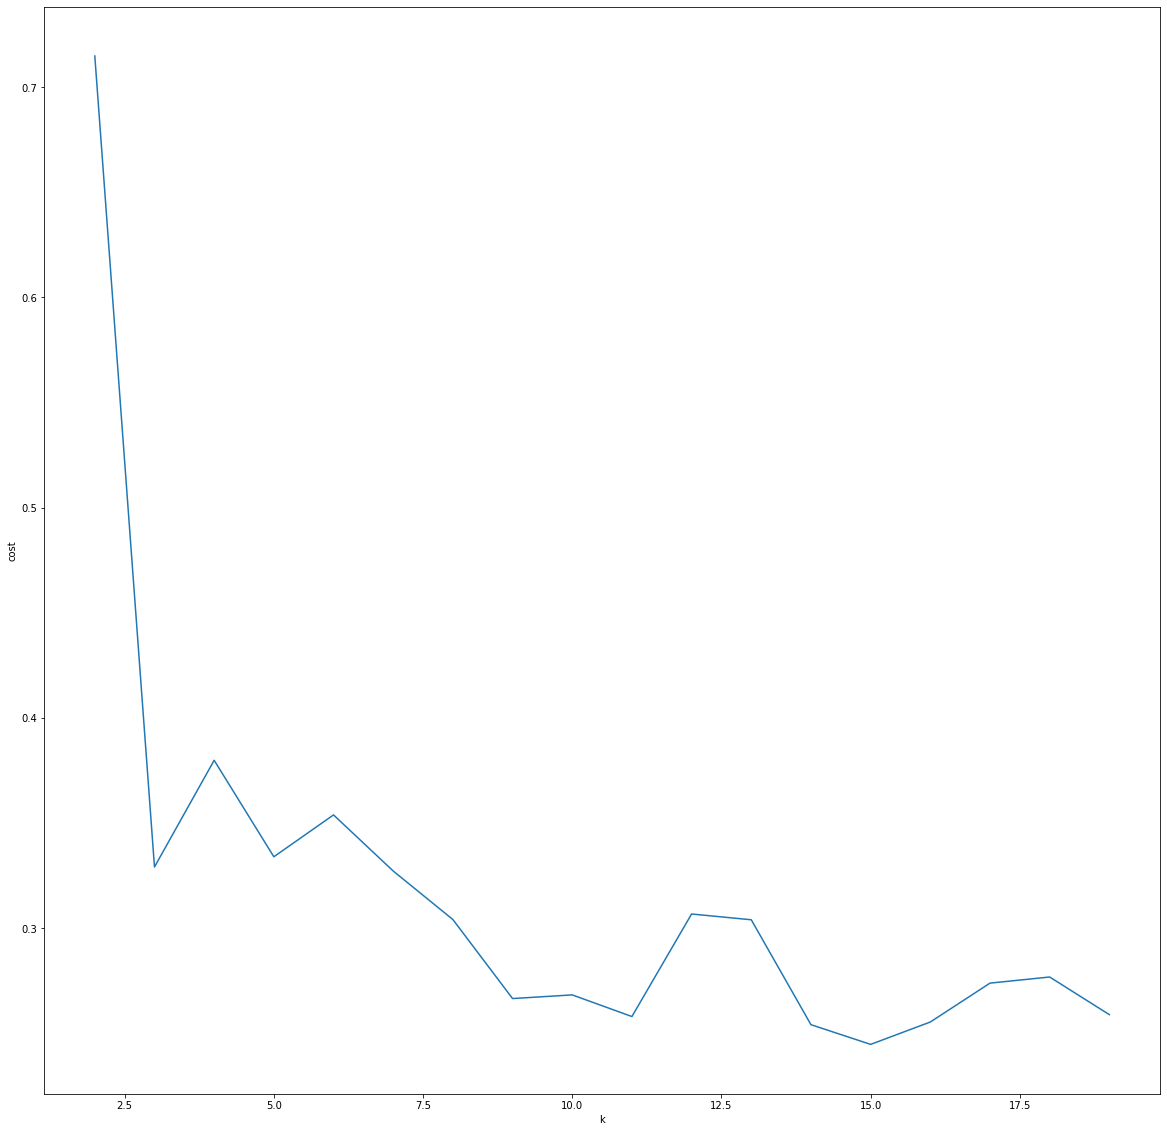

In [12]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(20,20))
ax.plot(range(2,20),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [13]:
mid_index = len(silhouette_score) // 2
mid_fit = silhouette_score[mid_index]
for i in range(mid_index-4, mid_index+4) :
    if mid_fit < silhouette_score[i]:
        print(i)
        print(mid_index+2)
        mid_fit = silhouette_score[i]
        mid_index = i

print(mid_fit)
print(mid_index)

5
11
0.32710313776682787
5


In [14]:
KMeans_algo=KMeans(featuresCol='standardized', k=mid_index+2)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)
centers = KMeans_fit.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.30810817  0.36186187  3.67181074  0.4671803   3.11591953  0.17548031
  1.15815614 -0.95253449  0.63509407  4.6663305  10.17335607]
[ 3.59072898e+00  3.31687170e+00  4.35525420e+00  6.05784183e-01
  2.49769539e+00  9.65648700e-03  1.31646834e+00 -9.45169500e-01
  3.39033008e+00  4.53413770e+00  1.01506477e+01]
[ 3.6743316   3.25936817  3.81773904  0.31193268  3.15881574  0.16416404
  3.13672118 -0.80166992  0.96430548  4.54313325 10.13482063]
[ 3.33461125  2.72806542  2.65323497  2.48026773  0.71749429  2.14739938
  0.80056497 -3.25429677  0.58617365  3.99058363  2.54333902]
[ 4.05189401  3.14768267  3.2243027   1.01296279  2.35526229  0.09671568
  0.93983291 -1.07572089  0.64842294  4.06655947  9.90187606]
[ 2.77847548  2.86774626  2.40618837  3.14110786  0.18026684  3.11630511
  0.73171413 -3.98892568  0.51125987  3.85420138  9.43496732]
[ 3.27144683  3.52346722  4.46227283  0.35304414  2.99438361  0.14957064
  0.93502501 -0.76330323  0.76332782  4.50193194 10.16

In [15]:
summary = KMeans_fit.summary
print(summary.clusterSizes)

[66, 112, 132, 10, 178, 93, 409]


In [16]:
output.toPandas()

,trackid,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,features,standardized,prediction
0,4fzsfWzRhPawzqhX8Qt9F3,Stronger,Graduation,Kanye West,2007-09-11,311866,81,0.617,0.00564,0.7170,0.000000,0.4080,-7.858,0.1530,103.992,4,"[311866.0, 81.0, 0.617, 0.00564, 0.717, 0.0, 0...","[5.331421474555815, 3.9886877026148757, 3.8141...",2
1,1xNcBAoUw8Hz6LqK2jt4Ff,Call on Me - Radio Mix,Call on Me (Radio Mix),Eric Prydz,2004-09-10,171360,73,0.597,0.00427,0.8370,0.001150,0.8390,-6.518,0.3750,126.342,4,"[171360.0, 73.0, 0.597, 0.00427, 0.837, 0.0011...","[2.9294388740032082, 3.5947432381590856, 3.690...",2
2,6Sy9BUbgFse0n0LPA5lwy5,Sandstorm,"Before the Storm, Special Edition",Darude,2001-01-01,225493,67,0.528,0.14100,0.9650,0.985000,0.0797,-7.984,0.0465,136.065,4,"[225493.0, 67.0, 0.528, 0.141, 0.965, 0.985, 0...","[3.8548550421078747, 3.2992848898172427, 3.263...",6
3,7jk7gqyEonmVVYahZN5zhW,Circus,Circus (Deluxe Version),Britney Spears,2008-12-02,192360,74,0.791,0.14700,0.7330,0.000381,0.0713,-5.215,0.0520,114.980,4,"[192360.0, 74.0, 0.791, 0.147, 0.733, 0.000381...","[3.288438736013405, 3.643986296216059, 4.88981...",6
4,4xkOaSrkexMciUUogZKVTS,'Till I Collapse,The Eminem Show,Eminem,2002-05-26,297786,83,0.548,0.06220,0.8470,0.000000,0.0816,-3.237,0.1860,171.447,4,"[297786.0, 83.0, 0.548, 0.0622, 0.847, 0.0, 0....","[5.0907206146937405, 4.087173818728823, 3.3876...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,67mEEKBy1ViwbTybbiH2nF,Ever Since,Ever Since,Rickard Nilsson,2021-06-11,184677,59,0.475,0.99100,0.0372,0.922000,0.1050,-23.104,0.0518,85.356,3,"[184677.0, 59.0, 0.475, 0.991, 0.0372, 0.922, ...","[3.157096072212246, 2.9053404253614525, 2.9363...",5
996,3nfhbwdfbK19V3vwRTAcoo,Purity,Purity,Cecile Roy,2021-07-05,147000,58,0.272,0.99300,0.0240,0.924000,0.0938,-27.869,0.0389,45.945,4,"[147000.0, 58.0, 0.272, 0.993, 0.024, 0.924, 0...","[2.5129990340713793, 2.856097367304479, 1.6814...",5
997,135YvfJTQSpHZFPJSL5Iyc,A Never Ending Cycle,A Never Ending Cycle,Javi Lobe,2021-08-20,190000,54,0.487,0.99500,0.0441,0.941000,0.0828,-25.204,0.0516,113.473,4,"[190000.0, 54.0, 0.487, 0.995, 0.0441, 0.941, ...","[3.2480939896160685, 2.6591251350765837, 3.010...",5
998,0ikGD2kxo348Cqxdb2jkzQ,Stay here,Stay here,Lara Di Umbra,2021-06-25,172500,59,0.284,0.99500,0.0223,0.941000,0.0912,-29.304,0.0373,99.990,4,"[172500.0, 59.0, 0.284, 0.995, 0.0223, 0.941, ...","[2.9489274379409043, 2.9053404253614525, 1.755...",5


In [17]:
## Store results in spark

kmeansout = output.drop(output.features)
kmeansout.show(2)
kmeansout.createOrReplaceTempView("kmoutput")

+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+----------+
|             trackid|                name|               album|    artist|release_date|length|popularity|danceability|acousticness|energy|instrumentalness|liveness|loudness|speechiness|  tempo|time_signature|        standardized|prediction|
+--------------------+--------------------+--------------------+----------+------------+------+----------+------------+------------+------+----------------+--------+--------+-----------+-------+--------------+--------------------+----------+
|4fzsfWzRhPawzqhX8...|            Stronger|          Graduation|Kanye West|  2007-09-11|311866|        81|       0.617|     0.00564| 0.717|             0.0|   0.408|  -7.858|      0.153|103.992|             4|[5.33142147455581...|         2|
|1xNcBAoUw8Hz6LqK2...|Call on Me

In [18]:
kmoutsql = sqlcontext.sql("SELECT * FROM kmoutput")
kmoutsql.toPandas()

,trackid,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,standardized,prediction
0,4fzsfWzRhPawzqhX8Qt9F3,Stronger,Graduation,Kanye West,2007-09-11,311866,81,0.617,0.00564,0.7170,0.000000,0.4080,-7.858,0.1530,103.992,4,"[5.331421474555815, 3.9886877026148757, 3.8141...",2
1,1xNcBAoUw8Hz6LqK2jt4Ff,Call on Me - Radio Mix,Call on Me (Radio Mix),Eric Prydz,2004-09-10,171360,73,0.597,0.00427,0.8370,0.001150,0.8390,-6.518,0.3750,126.342,4,"[2.9294388740032082, 3.5947432381590856, 3.690...",2
2,6Sy9BUbgFse0n0LPA5lwy5,Sandstorm,"Before the Storm, Special Edition",Darude,2001-01-01,225493,67,0.528,0.14100,0.9650,0.985000,0.0797,-7.984,0.0465,136.065,4,"[3.8548550421078747, 3.2992848898172427, 3.263...",6
3,7jk7gqyEonmVVYahZN5zhW,Circus,Circus (Deluxe Version),Britney Spears,2008-12-02,192360,74,0.791,0.14700,0.7330,0.000381,0.0713,-5.215,0.0520,114.980,4,"[3.288438736013405, 3.643986296216059, 4.88981...",6
4,4xkOaSrkexMciUUogZKVTS,'Till I Collapse,The Eminem Show,Eminem,2002-05-26,297786,83,0.548,0.06220,0.8470,0.000000,0.0816,-3.237,0.1860,171.447,4,"[5.0907206146937405, 4.087173818728823, 3.3876...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,67mEEKBy1ViwbTybbiH2nF,Ever Since,Ever Since,Rickard Nilsson,2021-06-11,184677,59,0.475,0.99100,0.0372,0.922000,0.1050,-23.104,0.0518,85.356,3,"[3.157096072212246, 2.9053404253614525, 2.9363...",5
996,3nfhbwdfbK19V3vwRTAcoo,Purity,Purity,Cecile Roy,2021-07-05,147000,58,0.272,0.99300,0.0240,0.924000,0.0938,-27.869,0.0389,45.945,4,"[2.5129990340713793, 2.856097367304479, 1.6814...",5
997,135YvfJTQSpHZFPJSL5Iyc,A Never Ending Cycle,A Never Ending Cycle,Javi Lobe,2021-08-20,190000,54,0.487,0.99500,0.0441,0.941000,0.0828,-25.204,0.0516,113.473,4,"[3.2480939896160685, 2.6591251350765837, 3.010...",5
998,0ikGD2kxo348Cqxdb2jkzQ,Stay here,Stay here,Lara Di Umbra,2021-06-25,172500,59,0.284,0.99500,0.0223,0.941000,0.0912,-29.304,0.0373,99.990,4,"[2.9489274379409043, 2.9053404253614525, 1.755...",5


# MODEL 2 - LYRICS EXTRACTION

In [19]:
## https://genius.com/api-clients

lyrics_subjects = sqlcontext.sql("SELECT trackid, name, album, artist FROM songs")
lyrics_subjects.toPandas()

,trackid,name,album,artist
0,4fzsfWzRhPawzqhX8Qt9F3,Stronger,Graduation,Kanye West
1,1xNcBAoUw8Hz6LqK2jt4Ff,Call on Me - Radio Mix,Call on Me (Radio Mix),Eric Prydz
2,6Sy9BUbgFse0n0LPA5lwy5,Sandstorm,"Before the Storm, Special Edition",Darude
3,7jk7gqyEonmVVYahZN5zhW,Circus,Circus (Deluxe Version),Britney Spears
4,4xkOaSrkexMciUUogZKVTS,'Till I Collapse,The Eminem Show,Eminem
...,...,...,...,...
995,67mEEKBy1ViwbTybbiH2nF,Ever Since,Ever Since,Rickard Nilsson
996,3nfhbwdfbK19V3vwRTAcoo,Purity,Purity,Cecile Roy
997,135YvfJTQSpHZFPJSL5Iyc,A Never Ending Cycle,A Never Ending Cycle,Javi Lobe
998,0ikGD2kxo348Cqxdb2jkzQ,Stay here,Stay here,Lara Di Umbra


In [20]:
os.environ['GENIUS_API_TOKEN']="ZqmoUelmG7iZBPQx8a1pn7QAWvThQsw2kmKRRivDle9auDcJg7fQYPy_RKx_jC6q"

In [84]:
genius = lyricsgenius.Genius(os.environ.get("GENIUS_API_TOKEN"))
column_names = ["trackid", "fulltext"]
words_df = pd.DataFrame(columns = column_names)

#for row in df.rdd.collect():
#    count+=1
#    print("Track number "+str(count)+" of "+str(size))
    # Format a request URL for the Genius API
    #search_term = row.name+" "+row.artist

def getText(lyrics):
    for language in stopwords.fileids():
        stop_words=set(stopwords.words("english")) 
        text_not_stop = [ word for word in lyrics if word not in stop_words ]
    return text_not_stop

def retrieveLyrics(song):
    lyrics = song.lyrics
    lyrics = str(lyrics)
    lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
    lyrics = re.sub('\n{2}','',lyrics)  # Remove gaps between verses  
    lyrics = re.sub('\n',' ',lyrics) # Remove single \n
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    lyrics = lyrics.lower()
    #lyrics = getText(lyrics) #to test
    return lyrics

def getWords(row):
    time.sleep(3)
    artist = genius.search_artist(row.artist, max_songs=1, sort="title")
    song = artist.song(row.name)
    if song is not None:
        #lyrics = song.lyrics
        #lyrics = str(lyrics)
        #lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
        #lyrics = re.sub('\n{2}','',lyrics)  # Remove gaps between verses  
        #lyrics = re.sub('\n',' ',lyrics) # Remove single \n
        #lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
        #lyrics = lyrics.lower()
        #word = lyrics.split()   #tokenizing all the lyrics body into individual words
        
        #for language in stopwords.fileids():
        #    stop_words=set(stopwords.words("english")) 
        #    text_not_stop = [ word for word in lyrics if word not in stop_words ]
        #print(retrieveLyrics(song))
        dat = pd.DataFrame.from_dict({'trackid': row.trackid, 'fulltext': [retrieveLyrics(song)] })
        return dat
    # words_df = words_df.append(words_df2, ignore_index = True)

#words_df = words_df.append(results)

In [ ]:
try:
    print(multiprocessing.cpu_count()-1)
    p = Pool(processes = (multiprocessing.cpu_count() - 1))
    words_df = words_df.append(p.map(getWords, df.rdd.collect()[:300]))
finally:
    p.close()
    p.join()

In [40]:
words_df

,trackid,fulltext
0,4fzsfWzRhPawzqhX8Qt9F3,work it make it do it makes us harder better ...
0,1xNcBAoUw8Hz6LqK2jt4Ff,call on me call on me call on me call on me ca...
0,6Sy9BUbgFse0n0LPA5lwy5,duuuuuuuuuuuuuuuuuuuuuuun dun dun dun dun dun...
0,7jk7gqyEonmVVYahZN5zhW,theres only two types of people in the world ...
0,4xkOaSrkexMciUUogZKVTS,cause sometimes you just feel tired yo left y...
...,...,...
0,50fXFVykkwS6Om9eqjTK44,take my hand let me make you mine im through ...
0,3HGnIIdHYIbkowzLk8UHbE,the weeknd take my breath aventura volví jac...
0,1tf4Bfk8JIKryLpWYRvyiI,its been a downpour beating on the tin roof it...
0,69AIpwGNLxr4qS1X5ynx60,few days before he turned 80 he was sitting o...


In [58]:
def getEmotions(words_df):
    column_names = ['trackid', 'words', 'Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']
    emolex_df = pd.DataFrame(columns = column_names)

    for index, row in words_df.iterrows():
        text = row['fulltext']
        text_object = NRCLex(text)

        if 'positive' in text_object.raw_emotion_scores.keys() :
            positive = text_object.raw_emotion_scores['positive']
        else:
            positive = 0

        if 'negative' in text_object.raw_emotion_scores.keys() :
            negative = text_object.raw_emotion_scores['negative']
        else:
            negative = 0

        if 'anger' in text_object.raw_emotion_scores.keys() :
            anger = text_object.raw_emotion_scores['anger']
        else:
            anger = 0

        if 'anticipation' in text_object.raw_emotion_scores.keys() :
            anticipation = text_object.raw_emotion_scores['anticipation']
        else:
            anticipation = 0

        if 'disgust' in text_object.raw_emotion_scores.keys() :
            disgust = text_object.raw_emotion_scores['disgust']
        else:
            disgust = 0

        if 'fear' in text_object.raw_emotion_scores.keys() :
            fear = text_object.raw_emotion_scores['fear']
        else:
            fear = 0

        if 'joy' in text_object.raw_emotion_scores.keys() :
            joy = text_object.raw_emotion_scores['joy']
        else:
            joy = 0

        if 'sadness' in text_object.raw_emotion_scores.keys() :
            sadness = text_object.raw_emotion_scores['sadness']
        else:
            sadness = 0

        if 'surprise' in text_object.raw_emotion_scores.keys() :
            surprise = text_object.raw_emotion_scores['surprise']
        else:
            surprise = 0

        if 'trust' in text_object.raw_emotion_scores.keys() :
            trust = text_object.raw_emotion_scores['trust']
        else:
            trust = 0

        emolex_df2 = {'trackid': row.trackid, 
                      'words': text_object.words,
                      'Positive': positive,
                      'Negative': negative,
                      'Anger': anger,
                      'Anticipation': anticipation,
                      'Disgust': disgust,
                      'Fear': fear,
                      'Joy': joy,
                      'Sadness': sadness,
                      'Surprise': surprise,
                      'Trust': trust }

        emolex_df = emolex_df.append(emolex_df2, ignore_index = True)
        
    return emolex_df


In [59]:
emolex_df = getEmotions(words_df)

,trackid,words,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,4fzsfWzRhPawzqhX8Qt9F3,"[work, it, make, it, do, it, makes, us, harder...",13,19,7,17,5,8,5,9,2,7
1,1xNcBAoUw8Hz6LqK2jt4Ff,"[call, on, me, call, on, me, call, on, me, cal...",0,8,0,0,8,0,0,0,0,0
2,6Sy9BUbgFse0n0LPA5lwy5,"[duuuuuuuuuuuuuuuuuuuuuuun, dun, dun, dun, dun...",0,41,0,0,0,0,0,0,0,0
3,7jk7gqyEonmVVYahZN5zhW,"[theres, only, two, types, of, people, in, the...",19,9,6,10,0,1,12,0,9,20
4,4xkOaSrkexMciUUogZKVTS,"[cause, sometimes, you, just, feel, tired, yo,...",17,45,26,7,28,27,4,23,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...
285,50fXFVykkwS6Om9eqjTK44,"[take, my, hand, let, me, make, you, mine, im,...",9,10,1,11,1,5,6,5,1,1
286,3HGnIIdHYIbkowzLk8UHbE,"[the, weeknd, take, my, breath, aventura, volv...",46,31,17,39,10,13,37,19,41,21
287,1tf4Bfk8JIKryLpWYRvyiI,"[its, been, a, downpour, beating, on, the, tin...",9,14,3,9,3,12,4,16,5,3
288,69AIpwGNLxr4qS1X5ynx60,"[few, days, before, he, turned, 80, he, was, s...",28,11,9,19,11,3,19,0,7,25


In [43]:
scores_df=emolex_df[['Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']]
cosine_sim=cosine_similarity(scores_df,scores_df)
cosine_sim.shape

(290, 290)

In [44]:
cosine_sim[0]

array([1.        , 0.50800051, 0.56875012, 0.73846246, 0.84357866,
       0.85881626, 0.78032437, 0.87731213, 0.47894747, 0.77857634,
       0.8828386 , 0.90232772, 0.94710628, 0.86531148, 0.79110371,
       0.78280348, 0.67284803, 0.92589804, 0.8652194 , 0.8063596 ,
       0.86878016, 0.85919895, 0.92666699, 0.85583783, 0.89535582,
       0.72590476, 0.87596558, 0.92285937, 0.84359598, 0.90751983,
       0.77090764, 0.81277544, 0.78302536, 0.89095865, 0.76250096,
       0.65356374, 0.71743672, 0.92271021, 0.82250031, 0.89597358,
       0.91256304, 0.85047118, 0.77188713, 0.73890096, 0.66788745,
       0.68705705, 0.67603659, 0.33102641, 0.71426396, 0.82923618,
       0.85740543, 0.86649556, 0.92179141, 0.80048271, 0.84323586,
       0.49027817, 0.8698577 , 0.90489478, 0.83180164, 0.88537446,
       0.89020598, 0.86373639, 0.80343037, 0.91645069, 0.97963654,
       0.7991994 , 0.83500431, 0.73338832, 0.94053642, 0.90070497,
       0.66950766, 0.8791138 , 0.87251028, 0.66883801, 0.86186

In [45]:
indices=pd.Series(emolex_df.index, emolex_df['trackid']).drop_duplicates()

In [46]:
def get_recommendations(title,indices,cosine_sim=cosine_sim):
    index=indices[title]
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    song_indices = [i[0] for i in sim_scores]
    return emolex_df['trackid'].iloc[song_indices]

In [47]:
get_recommendations('4fzsfWzRhPawzqhX8Qt9F3',indices)

64     7dyluIqv7QYVTXXZiMWPHW
186    27NovPIUIRrOZoCHxABJwK
260    27NovPIUIRrOZoCHxABJwK
130    3YRCqOhFifThpSRFJ1VWFM
116    1xShPgQbOUa98avWJQFDBY
285    50fXFVykkwS6Om9eqjTK44
244    5ChX0Yt1wPpRJFPPecJZPh
174    0vSiz90JRxvYsbCTx84oVM
142    2SiXAy7TuUkycRVbbWDEpo
12     4fbaKWFRghusXd4bSBvvfN
Name: trackid, dtype: object

# APPLICATION

In [62]:
if isDatabricks:
    dbutils.widgets.removeAll()

In [63]:
class PlayListAndName:
    def __init__(self, name, id):
        self.name = name
        self.id = id

In [64]:
myuser = '11154156130'
playlists = sp.user_playlists(myuser) #vulgs3g7788xjy1yu1plzoart #11154156130
user_playlists_id = []
playlists_names = [] 
for item in playlists['items']:
    print(item['id'])
    user_playlists_id.append(PlayListAndName(item['name'], item['id']))
    playlists_names.append(item['name'])

3igu3ANoW7hOw4pRFGQv10
7kaOZ9dEqJxg4dVz1pRqTa
0thLEQUrH9FXBSS3cDPBZa
5dTzrmFjY2BC0NqdPGoVEn
76jvxV82ehXXoLUsBXyJgp
35V5UEjIbdlHrwJT3oKM86
1g0etR4iS0u47QabBxYHLl
1eRI66Z8VdSHht95eGzKel
6vDGVr652ztNWKZuHvsFvx
37i9dQZF1DX0pH2SQMRXnC
3B4L1OptCi2otEOdrkxmDy
4Fyt2PWZxfUSOEm6hHOW7y
37i9dQZF1DXdLEN7aqioXM
37i9dQZF1DX32NsLKyzScr
37i9dQZF1DXaXB8fQg7xif
37i9dQZF1DX6wfQutivYYr
3hkeGEycSrpHNdOyDHnFvs
37i9dQZF1DWWMOmoXKqHTD
37i9dQZF1DWTC6XnyUt7U3
37i9dQZF1DX3rxVfibe1L0
37i9dQZF1DX3sDhLvLnzj8
2ncHRikVRNuiJzNcDuA7P8
37i9dQZF1DX186v583rmzp
2Cql7GHF4jWdcrIX7goZBW
37i9dQZF1DWWavShqgIPsw
6Oz4nqcXcZPYmcBYNkRmFP


In [100]:
result_km = None

def calculateKM(name, create_playlist, emotions):
    
    ### BASIC RECCOMENDATION USING K-MEANS
    user_tracks_ids = []
    
    for plys in user_playlists_id:
        if plys.name == name:
            playlist = sp.user_playlist(myuser, plys.id)
            for item in playlist['tracks']['items']: #[:50]:
                track = item['track']
                if track is not None:
                    user_tracks_ids.append(track['id'])  
    user_tracks = []
    
    for i in range(len(user_tracks_ids)):
        sys.stdout.write("\rProcessing Track Number %i" % i)
        sys.stdout.write("\Tracks Number %i" % len(user_tracks_ids))
        sys.stdout.flush()
        try:
            track = getTrackFeatures(user_tracks_ids[i])
            user_tracks.append(track)
        except:
            pass
    print(user_tracks)   
    userdf = pd.DataFrame(user_tracks, columns = ['trackid', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
    userdf = spark.createDataFrame(userdf)
    userdf.createOrReplaceTempView(myuser+"songs")
    myuser_spark_dataset = sqlcontext.sql("SELECT * FROM "+myuser+"songs")
    myuser_spark_dataset = myuser_spark_dataset.dropna()
    new_myuser_df = vecAssembler.transform(myuser_spark_dataset)
    myuser_data_scale=scale.fit(new_myuser_df)
    myuser_data_scale_output=myuser_data_scale.transform(new_myuser_df)
    myuser_output=KMeans_fit.transform(myuser_data_scale_output)

    recommender_km = myuser_output.select(myuser_output["prediction"]).drop_duplicates()
    reccomender_result_km = kmoutsql.join(recommender_km, ["prediction"], "inner")
    result_km = reccomender_result_km.drop_duplicates().sort(reccomender_result_km.popularity.desc()).drop("standardized").limit(15)
    
    track_list = result_km.select('trackid').collect()
    
    ## USING LYRICS EMOTION
    if emotions :
        column_names = ["trackid", "fulltext"]
        user_words_df = pd.DataFrame(columns = column_names)

        try:
            print(multiprocessing.cpu_count()-1)
            p = Pool(processes = (multiprocessing.cpu_count() - 1))
            user_words_df = user_words_df.append(p.map(getWords, userdf.rdd.collect()))
        finally:
            p.close()
            p.join()
        print(user_words_df)
        user_words_df = getEmotions(user_words_df)
        user_scores_df=user_words_df[['Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']]
        user_cosine_sim=cosine_similarity(user_scores_df,scores_df)
        
        emotion_tracks = []
        for index, row in user_words_df.iterrows():
            user_indices=pd.Series(user_words_df.index, user_words_df['trackid']).drop_duplicates()
            em = get_recommendations(row['trackid'],user_indices,user_cosine_sim)
            emotion_tracks.append(em)
    
        emotion_tracks_as_set = set(emotion_tracks)
        intersection = emotion_tracks_as_set.intersection(track_list)
        track_list = list(intersection)
        
    ## CREATE PLAYLIST SECTION
    if create_playlist :
        x = uuid.uuid1()
        playlist_name = "Generated playlist "+str(x)+"for user "+myuser
        playlistid = sp.user_playlist_create("11154156130", playlist_name, public=False, description='Generated playlist from ML Databricks')
        tracks_to_add = []
        for single_track in track_list :
            tracks_to_add.append(single_track.trackid)
        sp.user_playlist_add_tracks(myuser, playlistid['uri'], tracks_to_add)
        
    return track_list.toPandas()

In [101]:
if isDatabricks :
    dbutils.widgets.dropdown("names", playlists_names[0], [playlists_names[x] for x in range(len(playlists_names))], "Choose a playlist for user "+myuser)
else:
    user_stats = interact_manual(calculateKM, name=widgets.Dropdown(options=playlists_names), create_playlist=widgets.Dropdown(options=[True, False]), emotions=widgets.Dropdown(options=[True, False]))

In [96]:
try:
    val = getArgument("names")
except:
    pass
    
if isDatabricks:
    calculateKM(val)